## Transfer Learning with TensorFlow Part 1: Feature Extraction

### downloading the data and unzipping the data

In [1]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [2]:
# import zipfile

# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
# zip_ref.extractall()
# zip_ref.close()

In [3]:
# files in each folder
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

### data preparation

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMAGE_SHAPE,
                                            batch_size=BATCH_SIZE,
                                            class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


### Setting up callbacks (things to run whilst our model trains)
   Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

   * Tracking experiments with the TensorBoard callback
   * Model checkpoint with the ModelCheckpoint callback
   * Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [5]:
# creating tensflow callback
import datetime
from tensorflow.keras.callbacks import TensorBoard

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tb = TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tb

### Creating models using TensorFlow Hub

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as tfhub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

    Args:
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
          should be equal to number of target classes, default 10.
  
    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor
        layer and Dense output layer with num_classes output neurons.
    """
    
    # Download the pretrained model and save it as a Keras layer
    feature_extractor_layer = tfhub.KerasLayer(model_url,
                                              trainable=False, # freeze the already learned patterns
                                              name="feature_extraction_layer",
                                              input_shape=IMAGE_SHAPE+(3,))
    
    # Create our own model
    model = Sequential([
        feature_extractor_layer,
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    
    return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [24]:
# creating resnet model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [10]:
# compile resnet model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

resnet_model.compile(loss=categorical_crossentropy,
                    optimizer=Adam(),
                    metrics=["accuracy"]
                    )

In [11]:
# fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_data=test_data,
                validation_steps=len(test_data),
                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                      experiment_name="resnet50V2"
                                                      )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220121-211904
Epoch 1/5
24/24 [==============================] - 108s 5s/step - loss: 1.9209 - accuracy: 0.3507 - val_loss: 1.1992 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 105s 4s/step - loss: 0.9286 - accuracy: 0.7320 - val_loss: 0.8481 - val_accuracy: 0.7348
Epoch 3/5
24/24 [==============================] - 103s 4s/step - loss: 0.6338 - accuracy: 0.8293 - val_loss: 0.7679 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 102s 4s/step - loss: 0.5021 - accuracy: 0.8747 - val_loss: 0.7069 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 102s 4s/step - loss: 0.3959 - accuracy: 0.9187 - val_loss: 0.6749 - val_accuracy: 0.7820


In [15]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

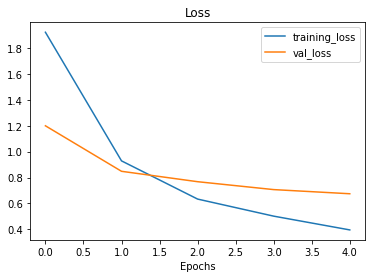

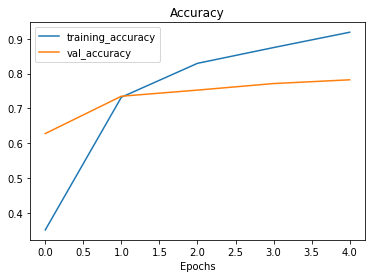

In [17]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [20]:
# create train_data_10_percent model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

# compile the model
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer="adam",
                          metrics=["accuracy"])

# fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220121-214304
Epoch 1/5
24/24 [==============================] - 71s 3s/step - loss: 1.8575 - accuracy: 0.4213 - val_loss: 1.3177 - val_accuracy: 0.7332
Epoch 2/5
24/24 [==============================] - 65s 3s/step - loss: 1.0694 - accuracy: 0.7773 - val_loss: 0.8734 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 66s 3s/step - loss: 0.7633 - accuracy: 0.8307 - val_loss: 0.6999 - val_accuracy: 0.8500
Epoch 4/5
24/24 [==============================] - 67s 3s/step - loss: 0.6132 - accuracy: 0.8667 - val_loss: 0.6090 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 67s 3s/step - loss: 0.5152 - accuracy: 0.8933 - val_loss: 0.5583 - val_accuracy: 0.8616


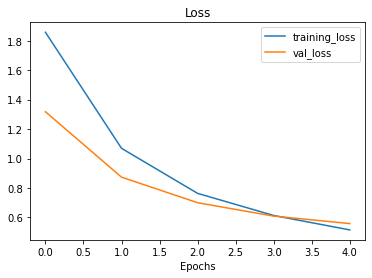

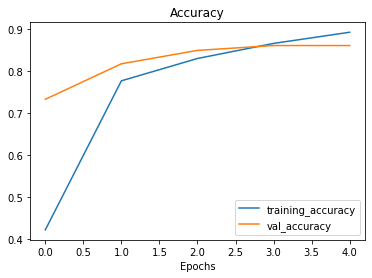

In [21]:
plot_loss_curves(efficientnet_history)

In [22]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________
